In [7]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
import pickle
import seaborn as sns


%matplotlib inline

In [8]:
# variables
M220_in = '/Volumes/Data/Emily/MAPseq/2301_MAPseq/python_analysis_M220/data_objects/'
M194_in = '/Volumes/Data/Emily/MAPseq/2206_MAPseq/python_anal/data_stuff/'

out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'

# import metadata
from M194_M220_metadata import *

#### load data
with open(M194_in +'M194_datasets.pkl', 'rb') as f:
    M194 = pickle.load(f)   
with open(M220_in +'M220_datasets.pkl', 'rb') as f:
    M220 = pickle.load(f)

# combine datasets
data = M194 + M220

#### load normalized data
with open(M194_in +'M194_datasetsN.pkl', 'rb') as f:
    M194_N = pickle.load(f)   
with open(M220_in +'M220_datasetsN.pkl', 'rb') as f:
    M220_N = pickle.load(f)

# combine datasets
dataN = M194_N + M220_N

# For normalized data, scale by 1000
# dataN = [df * 1000 for df in dataN]


# Clean up datasets
Drop extra collection area (RNc) in M220, remake column names so all the same

In [9]:
def clean_data_fxn(data_list, order, combine_targets=False, combine_inj=False):
    """
    Clean data for combined M194 and M220 data. Rename some areas so consistent b/w rounds of MAPseq
    
    data_list = list of data of M194 + M220 data
    order = order of brain areas to arrange final columns
    """
    
    cleaned_data = data_list.copy()
    
    # rearrange columns so that in same order
    for i in range(len(cleaned_data)):
        if i < 6:
            # M194 clean-up
            cleaned_data[i]["AOMCi"] = cleaned_data[i]["OMC-Ai"]
            cleaned_data[i]["POMCi"] = cleaned_data[i]["OMC-Pi"]
            cleaned_data[i]["AOMCc"] = cleaned_data[i]["OMC-Ac"]
            cleaned_data[i]["POMCc"] = cleaned_data[i]["OMC-Pc"]
            cleaned_data[i]["ACAi"] = cleaned_data[i]["ACA-i"]
            cleaned_data[i]["ACAc"] = cleaned_data[i]["ACA-c"]
            
            cleaned_data[i]["STRd"] = cleaned_data[i]["STR-d"]
            cleaned_data[i]["STRv"] = cleaned_data[i]["STR-v"]

            cleaned_data[i]["APAGd"] = cleaned_data[i]["PAG-Ad"]
            cleaned_data[i]["APAGv"] = cleaned_data[i]["PAG-Av"]
            cleaned_data[i]["PPAGd"] = cleaned_data[i]["PAG-Pd"]
            cleaned_data[i]["PPAGv"] = cleaned_data[i]["PAG-Pv"]

            cleaned_data[i]["AOMCi"] = cleaned_data[i]["OMC-Ai"]
            cleaned_data[i]["POMCi"] = cleaned_data[i]["OMC-Pi"]
            cleaned_data[i]["AOMCc"] = cleaned_data[i]["OMC-Ac"]
            cleaned_data[i]["POMCc"] = cleaned_data[i]["OMC-Pc"]
            
            

        else:
            # M220 clean-up                
            
            cleaned_data[i]["RN"] = cleaned_data[i]["RNi"]
            
            cleaned_data[i]["H2O_targ_ctl"] = cleaned_data[i]["H2O_ctl_targ"]
            cleaned_data[i]["H2O_inj_ctl"] = cleaned_data[i]["H2O_ctl_inj"]
            cleaned_data[i] = cleaned_data[i].drop("RNc", axis=1)

        if combine_targets:
            cleaned_data[i]["STR"] = cleaned_data[i]["STRd"] + cleaned_data[i]["STRv"]
            cleaned_data[i]["PAG"] = cleaned_data[i]["APAGd"] + cleaned_data[i]["APAGv"] + cleaned_data[i]["PPAGd"] + cleaned_data[i]["PPAGv"]
            cleaned_data[i]["OMCc"] = cleaned_data[i]["AOMCc"] + cleaned_data[i]["POMCc"]
            
        if combine_inj:
            cleaned_data[i]["OMCi"] = cleaned_data[i]["AOMCi"] + cleaned_data[i]["POMCi"]

                        
        cleaned_data[i] = cleaned_data[i][order]
        i+=1

        
    return cleaned_data
    

In [19]:
order = ['OB', 'AOMCi', 'POMCi', 'ACAi', 'OMCc',  'ACAc', 'AUD', 'STR', 'TH',
              'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'PAG', 'RN',
               'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']

data_clean = clean_data_fxn(data, order, combine_targets=True)
dataN_clean = clean_data_fxn(dataN, order, combine_targets=True)

# intermediate plot
Used to determine minimum target count threshold

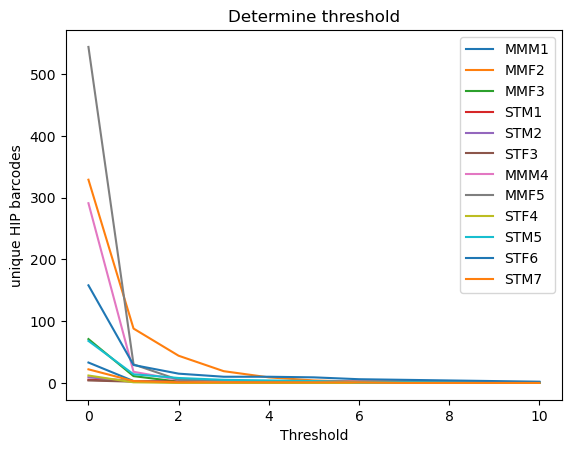

In [20]:
# determine threshold - based on below graph, threshold (conservative) can be set as 4
# Use Hippocampus (HIP) as negative control area

plot = pd.DataFrame(index=mice, columns=range(11))

for i in range(num_samples):
    for j in range(11):
        hip_u = (data_clean[i]["HIP"] > j).sum()
        plot.iloc[i,j] = hip_u

for i in range(num_samples):
    plt.plot(plot.iloc[i], label=mice[i])

plt.legend()
plt.xlabel('Threshold')
plt.ylabel("unique HIP barcodes")
plt.title("Determine threshold")
plt.show()

# seperate by individual areas

In [21]:
inj_sites = ["AOMCi", "POMCi", "ACAi"]
somc = "AOMCi|POMCi"
saca = "ACAi"

# create list for data_clean seperated by injection site (omc or aca)
dsC_omc = []
dsC_aca = []

for i in range(num_samples):
    inj = data_clean[i][inj_sites]
    omc_idx = inj.idxmax(axis=1).str.contains(somc)
    dsC_omc.append(data_clean[i][omc_idx])
    dsC_aca.append(data_clean[i][~omc_idx])

# seperate OMC/ACA of normalized dataset based on count dataset
dsCN_omc = []
dsCN_aca = []

dsCN = dataN_clean.copy()

for i in range(num_samples):
    omc_idx = dsC_omc[i].index
    aca_idx = dsC_aca[i].index
    dsCN_omc.append(dsCN[i].loc[omc_idx])
    dsCN_aca.append(dsCN[i].loc[aca_idx])



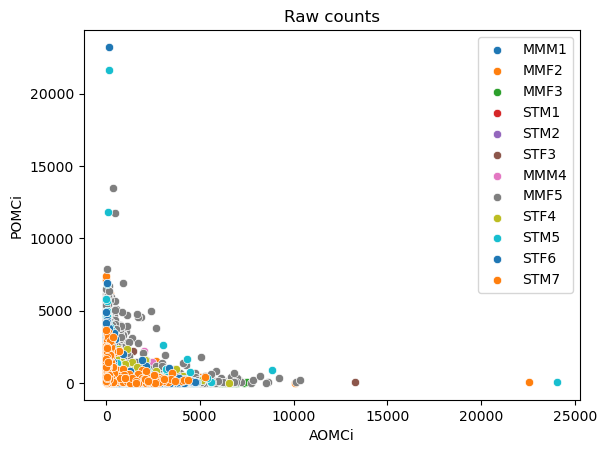

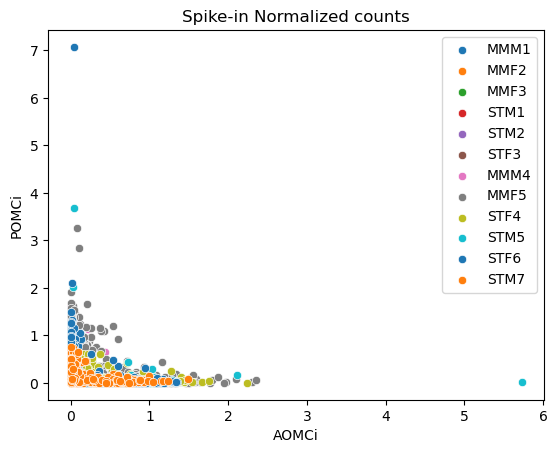

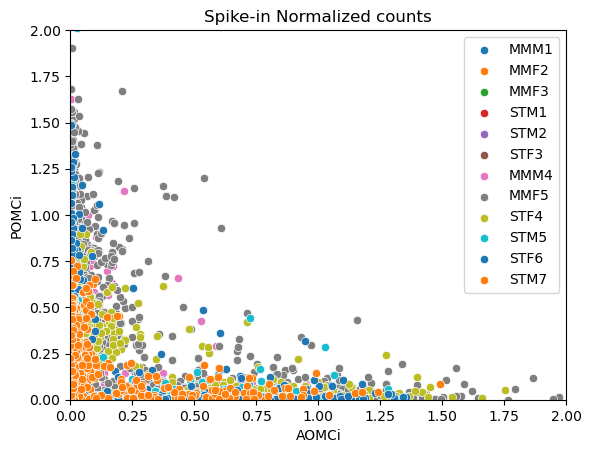

In [27]:
# plot AOMCi vs POMCi

# plot count data
for i in range(len(dsC_omc)):
    sns.scatterplot(dsC_omc[i], x="AOMCi", y="POMCi", label=metadata.loc[i,"mice"])
plt.title("Raw counts")
plt.show()

# plot normalized count data
for i in range(len(dsCN_omc)):
    sns.scatterplot(dsCN_omc[i], x="AOMCi", y="POMCi", label=metadata.loc[i,"mice"])
plt.title("Spike-in Normalized counts")
plt.show()

# plot normalized count data
for i in range(len(dsCN_omc)):
    sns.scatterplot(dsCN_omc[i], x="AOMCi", y="POMCi", label=metadata.loc[i,"mice"])
plt.title("Spike-in Normalized counts")
plt.ylim(0,2)
plt.xlim(0,2)
plt.show()

In [43]:
# assign OMCi expression values based on higher AOMCi/POMCi value

# do raw counts and normalized counts match?
print("MOUSE","\t", "TOTAL", "\t", "MATCH", "\t", "DIFFERENCE")
print("-"*35)
for i in range(metadata.shape[0]):

    df = dsC_omc[i]
    dfn = dsCN_omc[i]

    c_gr = df["AOMCi"]>df["POMCi"]
    cn_gr = dfn["AOMCi"]>dfn["POMCi"]

    total = len(c_gr)
    match = sum(c_gr == cn_gr)
    diff = total-match
    print(metadata.loc[i,"mice"], "\t", total, "\t", match, "\t", diff)

MOUSE 	 TOTAL 	 MATCH 	 DIFFERENCE
-----------------------------------
MMM1 	 11744 	 11641 	 103
MMF2 	 20572 	 20568 	 4
MMF3 	 13858 	 13607 	 251
STM1 	 669 	 664 	 5
STM2 	 504 	 504 	 0
STF3 	 388 	 388 	 0
MMM4 	 6454 	 6453 	 1
MMF5 	 19076 	 19073 	 3
STF4 	 982 	 977 	 5
STM5 	 542 	 542 	 0
STF6 	 1135 	 1133 	 2
STM7 	 894 	 889 	 5


In [57]:
# choose higher expression in AOMCi or POMCi
cols = ['OB', 'OMCi', 'ACAi', 'OMCc', 'ACAc', 'AUD', 'STR',
       'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'PAG', 'RN']

# count data
for i in range(len(dsC_omc)):
    df = dsC_omc[i]
    agp = df["AOMCi"] > df["POMCi"]
    df["OMCi"] = (agp*df["AOMCi"]) + (~agp*df["POMCi"])
    dsC_omc[i] = df[cols]

# normalized data
for i in range(len(dsCN_omc)):
    df = dsCN_omc[i]
    agp = df["AOMCi"] > df["POMCi"]
    df["OMCi"] = (agp*df["AOMCi"]) + (~agp*df["POMCi"])
    dsCN_omc[i] = df[cols]

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_20960/2226659635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OMCi"] = (agp*df["AOMCi"]) + (~agp*df["POMCi"])
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_20960/2226659635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OMCi"] = (agp*df["AOMCi"]) + (~agp*df["POMCi"])
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_20960/2226659635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [64]:
# set threshold=4
# under this threshold = false positive, so set to 0
omc_counts = []
aca_counts = []
for i in range(num_samples):
    omc_df = dsC_omc[i].copy()
    omc_df[omc_df <= 4] = 0
    aca_df = dsC_aca[i].copy()
    aca_df[aca_df <= 4] = 0
    omc_counts.append(omc_df)
    aca_counts.append(aca_df)
    

In [65]:
# SAVE DATA - COUNT DATA
with open(out_path + 'M194_M220_OMC_count.pkl', 'wb') as f:
    pickle.dump(omc_counts, f, protocol=-1)
    
with open(out_path + 'M194_M220_ACA_count.pkl', 'wb') as f:
    pickle.dump(aca_counts, f, protocol=-1)

In [66]:
# apply threshold to normalized data
omc_countsN = []
aca_countsN = []
for i in range(num_samples):
    df_omc = dsCN_omc[i]
    omc_thr = omc_counts[i].copy()
    omc_thr[omc_thr > 0] = 1
    omc_countsN.append(df_omc.mul(omc_thr))
    
    df_aca = dsCN_aca[i]
    aca_thr = aca_counts[i].copy()
    aca_thr[aca_thr > 0] = 1
    aca_countsN.append(df_aca.mul(aca_thr))

In [67]:
# SAVE DATA - normalized DATA
with open(out_path + 'M194_M220_OMC_countN.pkl', 'wb') as f:
    pickle.dump(omc_countsN, f, protocol=-1)
    
with open(out_path + 'M194_M220_ACA_countN.pkl', 'wb') as f:
    pickle.dump(aca_countsN, f, protocol=-1)

In [68]:
# binarize - SET THRESHOLD AS 4 AS DETERMINED ABOVE
omc_bin = []
aca_bin = []
for i in range(num_samples):
    omc_bin.append(pd.DataFrame(binarize(dsC_omc[i], threshold=4), columns=dsC_omc[i].columns))
    aca_bin.append(pd.DataFrame(binarize(dsC_aca[i], threshold=4), columns=dsC_aca[i].columns))
    


In [70]:
# SAVE DATA - BINARY
with open(out_path + 'M194_M220_OMC_bin.pkl', 'wb') as f:
    pickle.dump(omc_bin, f, protocol=-1)
    
with open(out_path + 'M194_M220_ACA_bin.pkl', 'wb') as f:
    pickle.dump(aca_bin, f, protocol=-1)